In [154]:
%run /content/drive/MyDrive/Colab\ Notebooks/gpt.ipynb

In [155]:
# from google.colab import drive
# drive.mount('/content/drive')

In [156]:
from importlib.metadata import version

pkgs = ["matplotlib",  # Plotting library
        "numpy",       # PyTorch & TensorFlow dependency
        "tiktoken",    # Tokenizer
        "torch",       # Deep learning library
        "tensorflow",  # For OpenAI's pretrained weights
        "pandas"       # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 2.0.2
tiktoken version: 0.9.0
torch version: 2.6.0+cu124
tensorflow version: 2.18.0
pandas version: 2.2.2


## Prepare Dataset

In [157]:
import pandas as pd

In [158]:
df = pd.read_csv("data.csv")
df.sample(10)

,Unnamed: 0,poem,topic
5939,5939,Oh happy shades—to me unblest!\n Friendly to...,nature
2765,2765,Away above a harborful\n ...,love
717,717,It doesn’t matter\nA damn what’s playing—\nIn ...,religion
9898,9898,"Among these latter busts we count by scores,\n...",arts&sciences
6717,6717,My mother says:\n\nWhen Mama tried to teach me...,relationships
4431,4431,"Crows, crows, crows, crows\nthen the slow flap...",nature
5721,5721,"A woman stepped outside, crumbled\ninto a loos...",nature
8277,8277,\n\n\nFor Erna Brodber\nBe ye my fictions; But...,arts&sciences
9577,9577,“Breadth. Circle. Desert. Monarch. Month. Wisd...,arts&sciences
2897,2897,"1\nIs that an attitude for a flower, to stand\...",love


In [159]:
df.shape
df.drop(columns=["Unnamed: 0"], inplace=True)

In [160]:
df.sample(10)

,poem,topic
1215,1 God twirled across the face of what cannot ...,religion
8361,I’m four\nat the hospital I was born in....,arts&sciences
3374,"Follow thy fair sun, unhappy shadow, Though th...",love
8855,My father’s been dead for thirty yearsbut when...,arts&sciences
5911,Who knows whether the sea heals or corrodes?\n...,nature
9726,"The clew paying out through his fingers, a def...",arts&sciences
8027,I bring my students to the Frick to see Frank\...,arts&sciences
10024,"\n\n\n ""The trees are mended.""...",arts&sciences
1745,my mother\nasking how\nto open a tab\non her l...,love
5002,That linkage of warnings sent a tremor through...,nature


In [161]:
def check_empty_poems(df):

    # Check for NaN (missing) or empty strings after stripping whitespace
    empty_poems = df[df["poem"].isna() | (df["poem"].str.strip() == "")]

    if empty_poems.empty:
        print("✅ No empty or missing poems found.")
    else:
        print(f"⚠️ Found {len(empty_poems)} empty or missing poems.")
        print(empty_poems[["poem", "topic"]])  # Show the problematic rows

    return empty_poems

# Example usage
check_empty_poems(df)


⚠️ Found 8 empty or missing poems.
                                                   poem          topic
84    \n \n\n\n \n\n\n \n\n\n \n\n\n \n\n\n \n\n\n \...       religion
2319                                               \n\n           love
4145                                         \n \n\n\n          nature
6132                                                     relationships
6325                                            \n \n\n  relationships
8035  \n \n\n\n \n\n\n \n\n\n \n\n\n \n\n\n \n\n\n \...  arts&sciences
8211                           \n \n\n\n \n\n\n \n\n\n   arts&sciences
9546                                          \n \n\n\n  arts&sciences


,poem,topic
84,\n \n\n\n \n\n\n \n\n\n \n\n\n \n\n\n \n\n\n \...,religion
2319,\n\n,love
4145,\n \n\n\n,nature
6132,,relationships
6325,\n \n\n,relationships
8035,\n \n\n\n \n\n\n \n\n\n \n\n\n \n\n\n \n\n\n \...,arts&sciences
8211,\n \n\n\n \n\n\n \n\n\n,arts&sciences
9546,\n \n\n\n,arts&sciences


In [162]:
def remove_empty_poems(df):

    # Remove rows where "poem" is NaN or just empty/whitespace
    cleaned_df = df[~(df["poem"].isna() | (df["poem"].str.strip() == ""))]

    # Show how many rows were removed
    removed_count = len(df) - len(cleaned_df)
    print(f"✅ Removed {removed_count} empty/missing poems.")

    return cleaned_df

# Example usage:
df = remove_empty_poems(df)


✅ Removed 8 empty/missing poems.


In [163]:
print(df["topic"].value_counts())


topic
nature           2428
arts&sciences    2180
love             2081
relationships    1805
religion         1562
Name: count, dtype: int64


In [164]:
import pandas as pd

def create_balanced_dataset(df):
    # Count the instances of "religion"
    num_religion = df[df["topic"] == "religion"].shape[0]

    # Sample other topics to match the count of "religion"
    nature_subset = df[df["topic"] == "nature"].sample(num_religion, random_state=123)
    arts_sciences_subset = df[df["topic"] == "arts&sciences"].sample(num_religion, random_state=123)
    love_subset = df[df["topic"] == "love"].sample(num_religion, random_state=123)
    relationships_subset = df[df["topic"] == "relationships"].sample(num_religion, random_state=123)
    religion_subset = df[df["topic"] == "religion"]

    # Combine all subsets into one balanced dataset
    balanced_df = pd.concat([
        relationships_subset,
        nature_subset,
        arts_sciences_subset,
        love_subset,
        religion_subset
    ])

    # Optional: Shuffle the final dataset
    balanced_df = balanced_df.sample(frac=1, random_state=123).reset_index(drop=True)

    return balanced_df

# Example usage
balanced_df = create_balanced_dataset(df)
print(balanced_df["topic"].value_counts())  # to confirm balance


topic
arts&sciences    1562
nature           1562
religion         1562
love             1562
relationships    1562
Name: count, dtype: int64


In [165]:
# Function to label topics
def label_topics(df):
    topic_label_map = {
        "relationships": 0,
        "nature": 1,
        "arts&sciences": 2,
        "love": 3,
        "religion": 4
    }
    df["topic"] = df["topic"].map(topic_label_map)
    return df

balanced_df = label_topics(balanced_df)
# print(balanced_df["topic"].value_counts())

In [166]:
balanced_df

,poem,topic
0,\n\n\n(*For LGBT Africans)\n\n\n\n\n(*For LGBT...,2
1,With her one horrid eye persistently unfastene...,1
2,I have been taught never to brag but now\nI ca...,1
3,At six I lived for spells:\nhow a few Hawaiian...,4
4,Someone once told me that animals are people u...,3
...,...,...
7805,"I was arrested because of that internal memo, ...",2
7806,Remember after work you grabbed our skateboard...,0
7807,"Her pencil poised, she's ready to create,\nThe...",2
7808,"\n\n\nRome, 15—\n\n\n\n\nRome, 15—\n\nRome, 15...",4


In [167]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [168]:
a = pd.read_csv("validation.csv")
a['topic'].value_counts()

,count
topic,
3,174
0,159
2,155
1,147
4,146


## Creating data loaders

In [169]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [170]:
def check_encoded_lengths(csv_file, tokenizer):
    df = pd.read_csv(csv_file)

    # Encode each poem
    encoded_texts = [tokenizer.encode(text) for text in df["poem"]]

    # Calculate lengths
    lengths = [len(tokens) for tokens in encoded_texts]

    # Print stats
    print(f"Number of samples: {len(lengths)}")
    print(f"Shortest encoded length: {min(lengths)}")
    print(f"Longest encoded length: {max(lengths)}")
    print(f"Average encoded length: {sum(lengths) / len(lengths):.2f}")

    # Optionally: Find index of longest/shortest
    longest_idx = lengths.index(max(lengths))
    shortest_idx = lengths.index(min(lengths))
    print("\nExample of longest poem:")
    print(df["poem"].iloc[longest_idx])
    print("\nExample of shortest poem:")
    print(df["poem"].iloc[shortest_idx])

# Example usage
check_encoded_lengths("train.csv", tokenizer)


Number of samples: 5467
Shortest encoded length: 3
Longest encoded length: 40861
Average encoded length: 464.31

Example of longest poem:



for DreamChad on the death of her sun Mark - mark this word mark this place + tyme - at Papine Kingston Jamaica - age 29 
midnight 28/29 April   2001-1002-0210-0120-0020-0000
rev 29 feb 04

 




for DreamChad on the death of her sun Mark - mark this word mark this place + tyme - at Papine Kingston Jamaica - age 29 
midnight 28/29 April   2001-1002-0210-0120-0020-0000
rev 29 feb 04

 

for DreamChad on the death of her sun Mark - mark this word mark this place + tyme - at Papine Kingston Jamaica - age 29 
midnight 28/29 April   2001-1002-0210-0120-0020-0000
rev 29 feb 04

 WHAT CAN I SAY BUT THIS MY DARLING
WHAT CAN I DO BUT TRY TO SPEECH MY HEART YR HEART FROM BREAKING

.
 ‘Kumina is the most African of the [cultural expressions] to be found in Jamaica, with negligible European or Christian influence. Linguistics evidence cites the Kongo as a spe

In [171]:
import torch
from torch.utils.data import Dataset
import pandas as pd  # Don't forget this import

class PoemTopicDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize poem texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["poem"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences to max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["topic"]  # ✅ Changed from "poem" to "Label"
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        return max(len(encoded_text) for encoded_text in self.encoded_texts)


In [172]:
train_dataset = PoemTopicDataset(
    csv_file="train.csv",
    max_length=500,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

500


In [173]:
val_dataset = PoemTopicDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = PoemTopicDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [174]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [175]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 500])
Label batch dimensions torch.Size([8])


In [176]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

683 training batches
98 validation batches
196 test batches


## Initializing a model with pretrained weights


In [177]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [178]:
import urllib.request
url = (
"https://raw.githubusercontent.com/rasbt/"
"LLMs-from-scratch/main/ch05/"
"01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x787aae90e290>)

In [179]:
from gpt_download import download_and_load_gpt2
# i have already runned gpt.py notebook in start which contains all funstions of  previous chapters so you can call thsese

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [180]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [181]:
text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


## Adding a classification head


In [182]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [183]:
# import torch.nn as nn

# def enable_dropout(model, dropout_prob=0.2):
#     for block in model.trf_blocks:
#         # Set dropout for attention
#         if hasattr(block.att, "dropout") and isinstance(block.att.dropout, nn.Dropout):
#             block.att.dropout.p = dropout_prob

#         # Set dropout for residual connection
#         if hasattr(block, "drop_resid") and isinstance(block.drop_resid, nn.Dropout):
#             block.drop_resid.p = dropout_prob

#         # Add dropout to feedforward if not already there
#         ff_layers = block.ff.layers
#         if isinstance(ff_layers, nn.Sequential):
#             new_ff = nn.Sequential(
#                 ff_layers[0],          # Linear(768 → 3072)
#                 ff_layers[1],          # GELU()
#                 nn.Dropout(dropout_prob),  # Inserted dropout
#                 ff_layers[2],          # Linear(3072 → 768)
#                 nn.Dropout(dropout_prob)   # Optional second dropout after projection
#             )
#             block.ff.layers = new_ff


In [184]:
# enable_dropout(model, dropout_prob=0.2)

In [185]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [186]:
for param in model.parameters():
    param.requires_grad = False

In [187]:
torch.manual_seed(123)

num_classes = 5
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [188]:
# Then, unfreeze the last 5 transformer blocks
for block in model.trf_blocks[-2:]:
    for param in block.parameters():
        param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True


## Calculating the classification loss and accuracy

In [189]:

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [190]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 20.00%
Validation accuracy: 22.50%
Test accuracy: 30.00%


In [191]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [192]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [193]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 4.616
Validation loss: 3.650
Test loss: 2.732


##  Finetuning the model on supervised data

In [194]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [195]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [196]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=150, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.915, Val loss 3.164
Ep 1 (Step 000150): Train loss 2.008, Val loss 1.916
Ep 1 (Step 000300): Train loss 1.624, Val loss 1.745
Ep 1 (Step 000450): Train loss 1.595, Val loss 1.708
Ep 1 (Step 000600): Train loss 1.548, Val loss 1.652
Training accuracy: 22.50% | Validation accuracy: 32.50%
Ep 2 (Step 000750): Train loss 1.572, Val loss 1.640
Ep 2 (Step 000900): Train loss 1.588, Val loss 1.638
Ep 2 (Step 001050): Train loss 1.535, Val loss 1.578
Ep 2 (Step 001200): Train loss 1.544, Val loss 1.645
Ep 2 (Step 001350): Train loss 1.565, Val loss 1.501
Training accuracy: 30.00% | Validation accuracy: 35.00%
Ep 3 (Step 001500): Train loss 1.355, Val loss 1.402
Ep 3 (Step 001650): Train loss 1.366, Val loss 1.222
Ep 3 (Step 001800): Train loss 1.205, Val loss 1.062
Ep 3 (Step 001950): Train loss 1.160, Val loss 1.079
Training accuracy: 65.00% | Validation accuracy: 62.50%
Ep 4 (Step 002100): Train loss 0.955, Val loss 1.033
Ep 4 (Step 002250): Train loss 1.184,

In [197]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

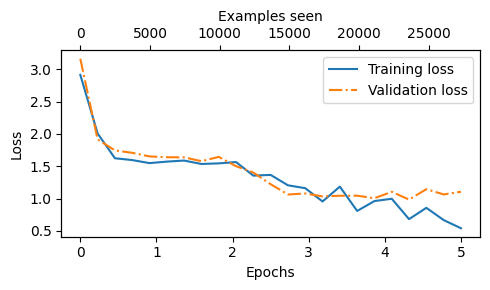

In [198]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

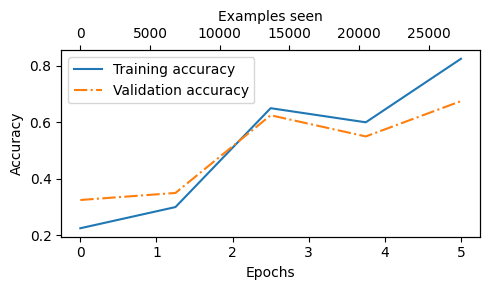

In [199]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [200]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 78.35%
Validation accuracy: 56.08%
Test accuracy: 51.41%


## Using the LLM as a Poem classifier

In [201]:
def classify_poem(text, model, tokenizer, device, max_length=500, pad_token_id=50256):
    model.eval()

    # Encode input
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    # Truncate if too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)  # Add batch dim

    # Inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Output logits for last token

    predicted_label = torch.argmax(logits, dim=-1).item()

    # Optional: Map back to topic name
    label_map = {
        0: "relationships",
        1: "nature",
        2: "arts&sciences",
        3: "love",
        4: "religion"
    }

    return label_map.get(predicted_label, f"Unknown ({predicted_label})")


In [203]:
text = "The stars above sing lullabies of love."
print(
    classify_poem(text, model, tokenizer,device ,max_length=train_dataset.max_length,)
)

nature


In [205]:
text = """These are your own words
your way of noticing
and saying plainly
of not turning away
from hurt
you have offered them
to me I am only
giving them back if only I could show you
how very useless
they are not"""

print(
    classify_poem(text, model, tokenizer,device ,max_length=train_dataset.max_length,)
)

arts&sciences


The model need to be improved more to get good results